In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import optuna

from scipy.stats import shapiro
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler,OneHotEncoder,PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

C:\Users\khadk\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=sns.load_dataset("healthexp")
df.shape

(274, 4)

In [3]:
df.head()

,Year,Country,Spending_USD,Life_Expectancy
0,1970,Germany,252.311,70.6
1,1970,France,192.143,72.2
2,1970,Great Britain,123.993,71.9
3,1970,Japan,150.437,72.0
4,1970,USA,326.961,70.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             274 non-null    int64  
 1   Country          274 non-null    object 
 2   Spending_USD     274 non-null    float64
 3   Life_Expectancy  274 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 8.7+ KB


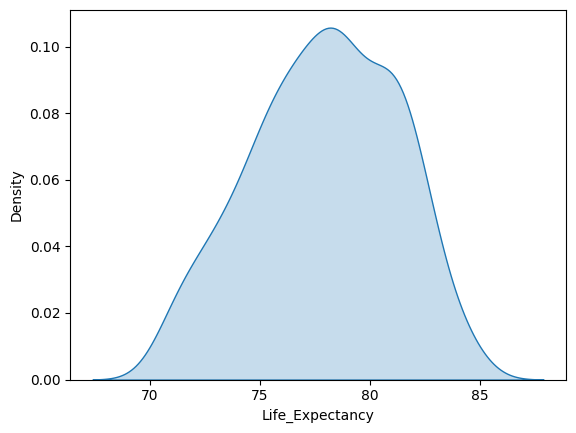

In [5]:
sns.kdeplot(df,x='Life_Expectancy',fill=True)
plt.show()

In [6]:
test,p_value=shapiro(df['Life_Expectancy'])
print(p_value)
if p_value<0.05:
    print("Reject null hypothesis. Life expectancy doesnot follow normal distributed")
else:
    print("Accept null hypothesis. Life expectancy is normally distributed")

0.0018645077446836037
Reject null hypothesis. Life expectancy doesnot follow normal distributed


In [7]:
X=df.drop(columns=['Life_Expectancy'])
X

,Year,Country,Spending_USD
0,1970,Germany,252.311
1,1970,France,192.143
2,1970,Great Britain,123.993
3,1970,Japan,150.437
4,1970,USA,326.961
...,...,...,...
269,2020,Germany,6938.983
270,2020,France,5468.418
271,2020,Great Britain,5018.700
272,2020,Japan,4665.641


In [8]:
Y=df['Life_Expectancy']
Y

0      70.6
1      72.2
2      71.9
3      72.0
4      70.9
       ... 
269    81.1
270    82.3
271    80.4
272    84.7
273    77.0
Name: Life_Expectancy, Length: 274, dtype: float64

In [9]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=10,test_size=10)

In [10]:
numerical_col=['Year','Spending_USD']

In [11]:
transformer=ColumnTransformer(transformers=[
    ("scaler",StandardScaler(),numerical_col),
    ("ohe",OneHotEncoder(drop="first",sparse_output=False,handle_unknown="ignore"),["Country"])
],remainder="passthrough")

In [12]:
pt=PowerTransformer()

In [13]:
Y_train_pt=pt.fit_transform(Y_train.values.reshape(-1,1))
Y_test_pt=pt.transform(Y_test.values.reshape(-1,1))

In [14]:
model=LinearRegression()

In [15]:
pipe=Pipeline([
    ("transformer",transformer),
    ("model",model)
])

In [16]:
pipe.fit(X_train,Y_train_pt.ravel())

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Year', 'Spending_USD']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Country'])])),
                ('model', LinearRegression())])

In [17]:
y_pred=pipe.predict(X_test)

In [18]:
y_pred_train=pipe.predict(X_train)

In [19]:
print(f"The test r2 score is {r2_score(Y_test_pt.ravel(),y_pred):.4f}")
print(f"The test mean squared error is {mean_squared_error(Y_test_pt.ravel(),y_pred):.4f}")

The test r2 score is 0.9894
The test mean squared error is 0.0101


In [20]:
print(f"The train r2 score is {r2_score(Y_train_pt.ravel(),y_pred_train):.4f}")
print(f"The train mean squared error is {mean_squared_error(Y_train_pt.ravel(),y_pred_train):.4f}")

The train r2 score is 0.9832
The train mean squared error is 0.0168


In [21]:
score=cross_val_score(pipe,X_train,Y_train_pt.ravel(),scoring="r2").mean()
print(score)

0.9804755535395742


In [22]:
score_mse=cross_val_score(pipe,X_train,Y_train_pt.ravel(),scoring="neg_mean_squared_error").mean()
print(-score_mse)

0.018914621832027568


### ML model using Optuna

In [23]:
#Objective Function:
def objective(trail):
    #Choose the algorithm to tune:
    classifier_name=trail.suggest_categorical('classifier',["SVM","RandomForest"])

    if classifier_name=="SVM":
        c=trail.suggest_float('c',0.1,100,log=True)
        kernel=trail.suggest_categorical("kernel",['linear','rbf','poly','sigmoid'])
        gamma=trail.suggest_categorical("gamma",['scale','auto'])

        model=SVR(C=c,kernel=kernel,gamma=gamma)

    elif classifier_name=="RandomForest":
        n_estimators=trail.suggest_int('n_estimators',50,1000)
        max_depth=trail.suggest_int('max_depth',10,50)
        min_samples_split=trail.suggest_int('min_samples_split',2,32)
        min_samples_leaf=trail.suggest_int('min_samples_leaf',1,32)

        model=RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf
        )
    
    clf = Pipeline(steps=[("transformer", transformer),
                          ("model", model)])
    scores=cross_val_score(clf,X_train,Y_train_pt.ravel(),cv=5,scoring="r2").mean()
    return score

In [24]:
study=optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=55)

[I 2025-09-16 21:56:52,648] A new study created in memory with name: no-name-4373b9d5-7b76-4537-843d-993c92867745
[I 2025-09-16 21:56:54,623] Trial 0 finished with value: 0.9804755535395742 and parameters: {'classifier': 'RandomForest', 'n_estimators': 645, 'max_depth': 50, 'min_samples_split': 25, 'min_samples_leaf': 25}. Best is trial 0 with value: 0.9804755535395742.
[I 2025-09-16 21:56:55,506] Trial 1 finished with value: 0.9804755535395742 and parameters: {'classifier': 'RandomForest', 'n_estimators': 267, 'max_depth': 27, 'min_samples_split': 29, 'min_samples_leaf': 27}. Best is trial 0 with value: 0.9804755535395742.
[I 2025-09-16 21:56:55,557] Trial 2 finished with value: 0.9804755535395742 and parameters: {'classifier': 'SVM', 'c': 22.599521386710883, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.9804755535395742.
[I 2025-09-16 21:56:55,628] Trial 3 finished with value: 0.9804755535395742 and parameters: {'classifier': 'SVM', 'c': 19.393228837172778, 'kerne

In [25]:
best_trial = study.best_trial
print("Best trial parameters:", best_trial.params)
print("Best trial accuracy:", best_trial.value)

Best trial parameters: {'classifier': 'RandomForest', 'n_estimators': 645, 'max_depth': 50, 'min_samples_split': 25, 'min_samples_leaf': 25}
Best trial accuracy: 0.9804755535395742


In [26]:
study.trials_dataframe()['params_classifier'].value_counts()

params_classifier
RandomForest    35
SVM             20
Name: count, dtype: int64